In [43]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
vlm = "miles"

if vlm == "clip":
    from CLIP.CLIPVLM import ClipVLM as VLM
    vlm = VLM(num_frames=10)
elif vlm == "miles":
    from MILES.wrapper import MILES_SimilarityVLM as VLM
    vlm = VLM()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


######USING ATTENTION STYLE:  frozen-in-time


In [230]:
from dataset import DatasetHandler
dataset = "moma_sact"
train_data = DatasetHandler(dataset, split="train")
val_data = DatasetHandler(dataset, split="val")
test_data = DatasetHandler(dataset, split="test")

dataset.moma.momaapi.lookup._read_anns() took 8.403647184371948 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.022177696228027344 sec
dataset.moma.momaapi.lookup._read_anns() took 1.121511697769165 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0010061264038085938 sec
dataset.moma.momaapi.lookup._read_anns() took 1.1289994716644287 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0009944438934326172 sec
dataset.moma.momaapi.lookup._read_anns() took 1.115957260131836 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0 sec
dataset.moma.momaapi.lookup._read_anns() took 1.1237092018127441 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0 sec


In [231]:
print("\n".join(train_data.data_dict.keys()))

one person is on their knees while proposing
one person is putting a ring on their partner
players are trying to catch a frisbee
the adult is chasing after the child on the bike
the adult is comforting the child
the adult is explaining to the child how to ride a bike
the adult is feeding the child
the adult is holding the child on the bike
the adult is playing with the child
the adult is pushing the stroller
the adult is wrapping the child or changing the child's diaper or clothes
the audience and host are cheering the award recipient on stage
the award winner is delivering a speech on stage
the barber is applying shampoo
the barber is combing hair
the barber is cutting hair with a razor
the barber is cutting hair with scissors
the barber is drying hair
the barber is massaging the customer's face or applying products
the barber is shaving a beard with a razor
the barber is shaving a beard with scissors
the barber is washing the customer's hair
the basketball player is dribbling or shoo

In [284]:
# Filter classes
CLASS_SETS = {
    "moma_sact": [
        [
            "the barber is combing hair",
            "the barber is cutting hair with a razor",
            "the barber is cutting hair with scissors",
            "the barber is drying hair",
            "the barber is washing the customer's hair"
        ],
        [
            "two people are hugging",
            "two people are kissing",
            "two people are talking"
        ],
        [
            "the security officer is inspecting a bag",
            "the security officer is inspecting a passenger"
        ],
        [
            "the firefighters are doing other work",
            "the firefighters are exiting the firetruck towards the scene",
            "the firefighters are extinguishing fire",
            "the firefighters are talking"
        ],
        list(val_data.data_dict.keys())
    ],
    "smsm": [
        [
            "putting something into something",
            "dropping something into something"
        ]
    ],
    "kinetics_100": [
        [
            "dancing ballet",
            "dancing charleston",
            "dancing macarena"
        ]
    ]
}
ALLOWED_CLASSES = CLASS_SETS[dataset][-1]

In [285]:
n_way = len(ALLOWED_CLASSES)
n_support = 5

class_names = np.array(ALLOWED_CLASSES)
support_videos = np.vstack([
    np.random.choice(train_data.data_dict[name], size=n_support, replace=False)
    for name in ALLOWED_CLASSES
])
query_videos = np.array([
    np.random.choice(test_data.data_dict[name])
    for name in ALLOWED_CLASSES
])

use_val_tuning = False
if use_val_tuning:
    val_videos = np.concatenate([
        val_data.data_dict[name]
        for name in ALLOWED_CLASSES
    ])
    val_labels = np.concatenate([
        [i] * len(val_data.data_dict[name])
        for i, name in enumerate(ALLOWED_CLASSES)
    ])
else:
    val_videos = None
    val_labels = None

In [286]:
classifiers = {}

from classifier.name_tuning import NameTuningFewShotClassifier
classifiers["clip"] = NameTuningFewShotClassifier(vlm) # Any of these classifiers can do zero-shot classification
classifiers["na"] = NameTuningFewShotClassifier(
    vlm,
    #prompt_ensemble_id="simple_photo",
    lr=5e-3,
    name_regularization=0.01,
    epochs=20,
    batch_size=8
)
from classifier.coop import CoopFewShotClassifier
classifiers["coop"] = CoopFewShotClassifier(
    vlm,
    lr=5e-3,
    epochs=20,
    batch_size=8
)
if False:
    from classifier.cona import CoNaFewShotClassifier
    classifiers["cona"] = CoNaFewShotClassifier(
        vlm,
        lr=1e-3,
        name_regularization=1,
        epochs=20,
        batch_size=8
    )

In [287]:
for name, classifier in classifiers.items():
    print(f"------ {name} ------")
    if name == "clip":
        classifier.predict(class_names, None, query_videos, val_videos, val_labels) # zero-shot classifier (i.e. default CLIP)
    else:
        classifier.predict(class_names, support_videos, query_videos, val_videos, val_labels)

------ clip ------
------ na ------


d:\ProgramData\Anaconda3\envs\vlm_env\lib\site-packages\torch\optim\lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch     0: Support Acc = 0.315, Loss = 2.380E+00, Reg Loss = 1.641E-09, Combined Loss = 2.380E+00
Epoch     1: Support Acc = 0.332, Loss = 2.174E+00, Reg Loss = 2.935E-04, Combined Loss = 2.174E+00
Epoch     2: Support Acc = 0.387, Loss = 1.826E+00, Reg Loss = 1.166E-03, Combined Loss = 1.828E+00
Epoch     3: Support Acc = 0.405, Loss = 1.733E+00, Reg Loss = 2.008E-03, Combined Loss = 1.735E+00
Epoch     4: Support Acc = 0.442, Loss = 1.583E+00, Reg Loss = 2.940E-03, Combined Loss = 1.586E+00
Epoch     5: Support Acc = 0.460, Loss = 1.516E+00, Reg Loss = 3.903E-03, Combined Loss = 1.520E+00
Epoch     6: Support Acc = 0.502, Loss = 1.419E+00, Reg Loss = 4.761E-03, Combined Loss = 1.424E+00
Epoch     7: Support Acc = 0.492, Loss = 1.403E+00, Reg Loss = 5.581E-03, Combined Loss = 1.409E+00
Epoch     8: Support Acc = 0.548, Loss = 1.312E+00, Reg Loss = 6.363E-03, Combined Loss = 1.318E+00
Epoch     9: Support Acc = 0.553, Loss = 1.304E+00, Reg Loss = 6.982E-03, Combined Loss = 1.311E+00


KeyboardInterrupt: 

### Classifier accuracy and tuned class tokens

In [36]:
for name, classifier in classifiers.items():
    print(f"------ {name} Class Probs ------")
    print("Accuracy:", (classifier.query_class_probabilities.argmax(axis=-1) == np.arange(len(class_names))).mean())
    print(f"Average correct-class prob: {classifier.query_class_probabilities[np.arange(len(class_names)), np.arange(len(class_names))].mean():.3f}")
    print(classifier.query_class_probabilities.round(3))

------ clip Class Probs ------
Accuracy: 0.4
Average correct-class prob: 0.397
[[0.074 0.11  0.078 0.059 0.679]
 [0.13  0.583 0.233 0.024 0.03 ]
 [0.117 0.45  0.373 0.022 0.038]
 [0.168 0.166 0.144 0.144 0.378]
 [0.049 0.075 0.029 0.032 0.814]]
------ na Class Probs ------
Accuracy: 0.6
Average correct-class prob: 0.430
[[0.016 0.011 0.013 0.114 0.846]
 [0.148 0.552 0.144 0.099 0.057]
 [0.117 0.247 0.442 0.073 0.121]
 [0.535 0.04  0.041 0.307 0.076]
 [0.026 0.045 0.018 0.079 0.832]]
------ coop Class Probs ------
Accuracy: 0.6
Average correct-class prob: 0.423
[[0.042 0.055 0.051 0.112 0.739]
 [0.077 0.605 0.197 0.034 0.086]
 [0.072 0.327 0.372 0.075 0.155]
 [0.246 0.102 0.109 0.265 0.278]
 [0.034 0.053 0.032 0.051 0.831]]


In [37]:
def most_similar_words(word_embedding: torch.Tensor, k=1):
    token_embeds = vlm.model.text_model.embeddings.token_embedding.weight
    token_embeds = F.normalize(token_embeds, dim=1)
    word_embedding = F.normalize(word_embedding, dim=0)
    similarities = token_embeds @ word_embedding
    
    best = torch.topk(similarities, k, largest=True)
    similarities = best.values.cpu().tolist()
    tokens = best.indices
    words = [vlm.tokenizer.decode(t) for t in tokens]
    
    return words, similarities

def closest_words(word_embedding: torch.Tensor, k=1):
    distances = torch.norm(vlm.model.text_model.embeddings.token_embedding.weight - word_embedding.unsqueeze(0), dim=1)
    
    best = torch.topk(distances, k, largest=False)
    distances = best.values.cpu().tolist()
    tokens = best.indices
    words = [vlm.tokenizer.decode(t) for t in tokens]
    
    return words, distances

def print_tuned_names(classifier, k=1):
    tuned_name_embeds, attn_mask = classifier.tuned_input_embeds
    for category_ind in range(n_way):
        n_tokens = attn_mask[category_ind].sum().type(torch.long)
        start_token_ind = vlm.text_start_special_token_count()
        end_token_ind = n_tokens - vlm.text_end_special_token_count()
        
        # Print a line for most similar replacements, then next most similar, etc
        lines = [[] for _ in range(k)]
        for token_ind in range(start_token_ind, end_token_ind):
            # words, values = most_similar_words(tuned_name_embeds[category_ind, token_ind], k)
            words, values = closest_words(tuned_name_embeds[category_ind, token_ind], k)
            for i in range(k):
                lines[i] += [f"{words[i]} ({values[i]:.3f})"]
                #lines[i] += [words[i]]
        for line in lines:
            print(" ".join(line))

for name, classifier in classifiers.items():
    if name == "clip":
        continue
    print_tuned_names(classifier)

the  (0.008) barber  (0.024) is  (0.012) comb (0.032) ing  (0.019) hair  (0.013)
the  (0.008) barber  (0.026) is  (0.012) cutting  (0.015) hair  (0.013) with  (0.008) a  (0.006) razor  (0.018)
the  (0.007) barber  (0.022) is  (0.008) cutting  (0.014) hair  (0.012) with  (0.008) scissors  (0.022)
the  (0.012) barber  (0.029) is  (0.011) drying  (0.026) hair  (0.015)
the  (0.012) barber  (0.046) is  (0.018) washing  (0.029) the  (0.012) customer  (0.020) 's  (0.009) hair  (0.018)
0 (0.471) 0 (0.453) sundaywithmarsha  (0.441) flyeagles (0.438) instaweather (0.463) 0 (0.463) 0 (0.444) 0 (0.462) 0 (0.449) 0 (0.464) 0 (0.452) 0 (0.454) flyeagles (0.456) 0 (0.459) flyeagles (0.441) 0 (0.432) the  (0.000) barber  (0.000) is  (0.000) comb (0.000) ing  (0.000) hair  (0.000)
0 (0.471) 0 (0.453) sundaywithmarsha  (0.441) flyeagles (0.438) instaweather (0.463) 0 (0.463) 0 (0.444) 0 (0.462) 0 (0.449) 0 (0.464) 0 (0.452) 0 (0.454) flyeagles (0.456) 0 (0.459) flyeagles (0.441) 0 (0.432) the  (0.000) b

### Output Text Embedding Comparison Diagram

In [ ]:
use_vids_in_sne = True
perplexity = 30


# Record saved as {class name -> [orig text embed, tuned text embed epoch 0, epoch 1, ...]}
orig_text_embeds_per_category = np.array([vlm.get_text_embeds(name) for name in class_names])
na_text_embeds_per_category = np.array([classifiers["na"].text_embed_training_record[name][-1] for name in class_names])
coop_text_embeds_per_category = np.array([classifiers["coop"].text_embed_training_record[name][-1] for name in class_names])

support_video_embeds = np.array([
    [
        vlm.get_video_embeds(path)
        for path in paths
    ]
    for paths in support_videos
])

# TSNE transform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sklearn_metric = "cosine"

stacked_embeddings = []
stacked_embeddings.append(orig_text_embeds_per_category)
stacked_embeddings.append(na_text_embeds_per_category)
stacked_embeddings.append(coop_text_embeds_per_category)
if use_vids_in_sne:
    stacked_embeddings.append(support_video_embeds.reshape(n_way * n_support, -1))
stacked_embeddings = np.concatenate(stacked_embeddings, axis=0)
sne_embeddings = TSNE(n_components=2, metric=sklearn_metric, perplexity=perplexity).fit_transform(stacked_embeddings)

next_ind = 0
orig_text_sne = sne_embeddings[next_ind : next_ind + n_way]
next_ind += n_way
na_text_sne = sne_embeddings[next_ind : next_ind + n_way]
next_ind += n_way
coop_text_sne = sne_embeddings[next_ind : next_ind + n_way]
next_ind += n_way
if use_vids_in_sne:
    support_video_sne = sne_embeddings[next_ind : next_ind + n_way * n_support].reshape(n_way, n_support, 2)
    next_ind += n_way * n_support

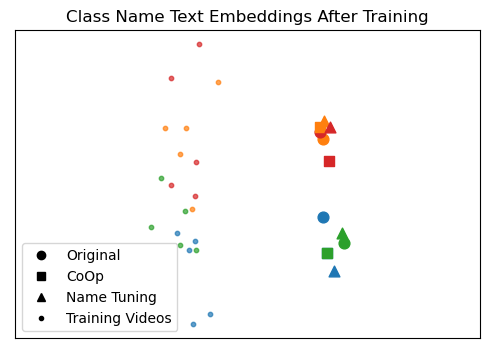

In [ ]:
show_vids = True

method_names = ["Original", "CoOp", "Name Tuning"]
method_markers = ["o", "s", "^"]
method_text_embeds = [orig_text_sne, coop_text_sne, na_text_sne]

color_cycler = iter(plt.cycler("color", plt.cm.tab10.colors))
class_colors = [next(color_cycler)["color"] for _ in class_names]

fig = plt.figure(figsize=(6, 4))

# Plot videos
if use_vids_in_sne and show_vids:
    for color, video_embeds in zip(class_colors, support_video_sne):
        plt.scatter(video_embeds[:, 0], video_embeds[:, 1], s=10, color=color, alpha=0.7)

# Plot text for each method
for name, marker, text_embeds in zip(method_names, method_markers, method_text_embeds):
    for color, class_text_embed in zip(class_colors, text_embeds):
        plt.scatter([class_text_embed[0]], [class_text_embed[1]], color=color, marker=marker, s=60)

# Create legend
legend_entries = [
    mlines.Line2D([], [], marker=marker, label=name, color="black", linestyle="None")
    for name, marker in zip(method_names, method_markers)
]
if use_vids_in_sne and show_vids:
    legend_entries.append(mlines.Line2D([], [], label="Training Videos", marker=".", color="black", linestyle="None"))
plt.legend(handles=legend_entries)

plt.axis("equal")

plt.title("Class Name Text Embeddings After Training")
plt.xticks([])
plt.yticks([])
plt.savefig(f"text_embed_separation.method_markers.vids_{use_vids_in_sne and show_vids}.pdf")
plt.show()

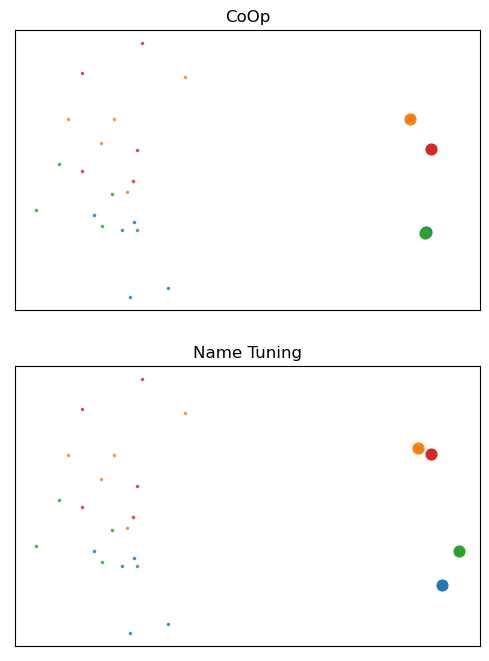

In [ ]:
show_vids = True

method_names = ["CoOp", "Name Tuning"]
method_text_embeds = [coop_text_sne, na_text_sne]

color_cycler = iter(plt.cycler("color", plt.cm.tab10.colors))
class_colors = [next(color_cycler)["color"] for _ in class_names]

fig,axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True, sharey=True)


# Plot text for each method
for i, (name, text_embeds) in enumerate(zip(method_names, method_text_embeds)):
    ax = axs[i]
    
    if use_vids_in_sne and show_vids:
        for color, video_embeds, class_text_embed in zip(class_colors, support_video_sne, text_embeds):
            ax.scatter(video_embeds[:, 0], video_embeds[:, 1], s=10, color=color, marker=".", alpha=0.7)
            ax.scatter([class_text_embed[0]], [class_text_embed[1]], color=color, marker="o")
    else:
        for color, class_text_embed in zip(class_colors, text_embeds):
            ax.scatter([class_text_embed[0]], [class_text_embed[1]], color=color, marker="o")
            
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

#plt.axis("equal")

plt.xticks([])
plt.yticks([])
plt.savefig(f"text_embed_separation.method_markers.vids_{use_vids_in_sne and show_vids}.pdf")
plt.show()

# Average Similarity between Class Embeds

In [278]:
for name, text_embeds in zip(method_names, method_text_embeds):
    text_embeds = torch.from_numpy(text_embeds)
    similarities = F.cosine_similarity(text_embeds.unsqueeze(0).expand(n_way, n_way, -1), text_embeds.unsqueeze(1).expand(n_way, n_way, -1), dim=-1)
    similarities *= (1 - torch.eye(n_way))
    mean_class_similarity = similarities.sum(dim=(0,1)) / (n_way * (n_way - 1))
    print(f"{name}: {mean_class_similarity:.3f}")
    
for name, text_embeds in zip(method_names, method_text_embeds):
    text_embeds = torch.from_numpy(text_embeds)
    distances = torch.norm(text_embeds.unsqueeze(0) - text_embeds.unsqueeze(1), dim=-1)
    distances *= (1 - torch.eye(n_way))
    mean_class_distance = distances.sum(dim=(0,1)) / (n_way * (n_way - 1))
    print(f"{name}: {mean_class_distance:.3f}")

Original: 1.000
CoOp: 1.000
Name Tuning: 1.000
Original: 0.329
CoOp: 0.363
Name Tuning: 0.434


In [42]:
# Get tuned class name embeddings
orig_name_embeds, _ = vlm.get_input_word_embeddings(ALLOWED_CLASSES)
tuned_name_embeds, attn_mask = classifier.tuned_input_embeds[0]
tuned_name_offset = tuned_name_embeds - orig_name_embeds

NameError: name 'classifier' is not defined

In [ ]:
print("Original name embed norms:", torch.norm(orig_name_embeds, dim=-1).mean().item())
print("Tuned name embed norms:", torch.norm(tuned_name_embeds, dim=-1).mean().item())
print("Tuned name offset norms:", torch.norm(tuned_name_offset, dim=-1).mean().item())

print("\nOffset norms per class:")
offset_norms = torch.norm(tuned_name_offset, dim=-1)
for category_ind in range(n_way):
    start_token_ind = vlm.text_start_special_token_count()
    end_token_ind = attn_mask[category_ind].sum() - vlm.text_end_special_token_count()
    print(" - ", class_names[category_ind])
    print("   ", " ".join([f"{norm:.2f}" for norm in offset_norms[category_ind, start_token_ind:end_token_ind]]))

Original name embed norms: 0.3848233222961426
Tuned name embed norms: 0.8528121709823608
Tuned name offset norms: 0.5832348465919495

Offset norms per class:
 -  dancing ballet
    0.84 1.00
 -  dancing charleston
    1.23 1.55
 -  dancing macarena
    1.18 1.94 1.00


In [ ]:
def print_similarity_per_token(embed):
    similarity = F.cosine_similarity(
        embed.unsqueeze(0).expand(n_way, n_way, *embed.shape[1:]),
        embed.unsqueeze(1).expand(n_way, n_way, *embed.shape[1:]),
        dim=-1
    ).cpu()
    similarity *= (1 - torch.eye(n_way).unsqueeze(2))
    similarity = similarity.sum(dim=(0, 1)) / (n_way * (n_way - 1))
    similarity = similarity[1:-1]
    print(" - ", " ".join([f"{s.item():.2f}" for s in similarity]))

print("\nOriginal name token similarity:")
print_similarity_per_token(orig_name_embeds)

print("\nTuned name token similarity:")
print_similarity_per_token(tuned_name_embeds)

print("\nTuned name offset token similarity:")
print_similarity_per_token(tuned_name_offset)


Original name token similarity:
 -  1.00 0.01 0.31

Tuned name token similarity:
 -  0.05 -0.05 0.32

Tuned name offset token similarity:
 -  -0.02 -0.06 0.00


In [ ]:
def closest_words(word_embedding: torch.Tensor, k=1):
    distances = torch.norm(vlm.model.text_model.embeddings.token_embedding.weight - word_embedding.unsqueeze(0), dim=1)
    
    best = torch.topk(distances, k, largest=False)
    distances = best.values.cpu().tolist()
    tokens = best.indices
    words = [vlm.tokenizer.decode(t) for t in tokens]
    
    return words, distances

k = 4
for category_ind in range(n_way):
    n_tokens = attn_mask[category_ind].sum()
    start_token_ind = vlm.text_start_special_token_count()
    end_token_ind = n_tokens - vlm.text_end_special_token_count()
    
    # Print a line for most similar replacements, then next most similar, etc
    lines = [[] for _ in range(k)]
    for token_ind in range(start_token_ind, end_token_ind):
        words, distances = closest_words(tuned_name_embeds[category_ind, token_ind], k)
        for i in range(k):
            #lines[i] += [f"{words[i]} ({distances[i]:.3f})"]
            lines[i] += [words[i]]
    for line in lines:
        print(" ".join(line))
    print("\n")

dancing  ballet 
dance  recital 
belle erts 
legacy  bly


dancing  charleston 
madhuridixit  tooting 
sleet  memph
poles  telford 


punjab <|startoftext|> arena 
luxury >  pier 
tamil  that  stadium 
dancing  for  fountain 




In [ ]:
def closest_words_along_line(base_embed: torch.Tensor, direction_embed: torch.Tensor, k=1):
    token_embeds = vlm.model.text_model.embeddings.token_embedding.weight
    rel_token_embeds = token_embeds - base_embed
    rel_token_embeds_parallel_component = rel_token_embeds @ F.normalize(direction_embed, dim=0)
    rel_token_embeds_along_dir = F.normalize(direction_embed, dim=0).unsqueeze(0) * rel_token_embeds_parallel_component.unsqueeze(1)
    rel_token_embeds_perpendicular = rel_token_embeds - rel_token_embeds_along_dir
    
    distances = torch.norm(rel_token_embeds_perpendicular, dim=1)
    
    # Rule out matches that are in opposite direction to direction_embed
    # Also rule out matches that are very close to base_embed
    #distances[rel_token_embeds_parallel_component <= 0.5] += 1000
    
    best = torch.topk(distances, k, largest=False)
    distances = best.values.cpu().tolist()
    tokens = best.indices
    words = [vlm.tokenizer.decode(t) for t in tokens]
    
    parallel_multiplier = (rel_token_embeds_parallel_component[tokens] / torch.norm(direction_embed, dim=0)).tolist()
    
    return words, distances, parallel_multiplier

k = 4
for category_ind in range(n_way):
    n_tokens = attn_mask[category_ind].sum()
    start_token_ind = vlm.text_start_special_token_count()
    end_token_ind = n_tokens - vlm.text_end_special_token_count()
    
    # Print a line for most similar replacements, then next most similar, etc
    lines = [[] for _ in range(k)]
    for token_ind in range(start_token_ind, end_token_ind):
        words, distances, parallel_multiplier = closest_words_along_line(orig_name_embeds[category_ind, token_ind], tuned_name_offset[category_ind, token_ind], k)
        for i in range(k):
            lines[i] += [f"{words[i]} ({distances[i]:.3f}, {parallel_multiplier[i]:.3f})"]
    for line in lines:
        print(" ".join(line))
    print("\n")

dancing  (0.000, 0.000) ballet  (0.000, 0.000)
dance  (0.259, 0.019) 2 (0.298, -0.041)
coscino  (0.290, -0.002) 0 (0.298, -0.041)
0 (0.291, -0.002) 1 (0.298, -0.041)


dancing  (0.000, 0.000) charleston  (0.000, 0.000)
dance  (0.259, -0.008) 2 (0.301, -0.007)
coscino  (0.290, -0.011) 0 (0.301, -0.007)
0 (0.290, -0.011) 1 (0.301, -0.007)


dancing  (0.000, 0.000) mac (0.000, 0.000) arena  (0.000, 0.000)
dance  (0.260, 0.005) 2 (0.272, 0.005) 2 (0.291, -0.018)
coscino  (0.290, 0.015) 0 (0.272, 0.005) 0 (0.291, -0.018)
0 (0.290, 0.013) 1 (0.272, 0.005) 1 (0.291, -0.018)


